# 3.2 线性回归的从零开始实现

In [1]:
%matplotlib inline
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random

print(torch.__version__)

1.5.0


## 3.2.1 生成数据集

我们构造一个简单的人工训练数据集，它可以使我们能够直观比较学到的参数和真实的模型参数的区别。设训练数据集样本数为1000，输入个数（特征数）为2。
给定随机生成的批量样本特征 X∈R1000×2，我们使用线性回归模型真实权重 w=[2,−3.4]⊤
和偏差 b=4.2，以及一个随机噪声项 ϵ 来生成标签

In [2]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = torch.randn(num_examples, num_inputs,
                      dtype=torch.float32)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b # ? 为什么不直接矩阵乘向量？
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()),
                       dtype=torch.float32)

In [3]:
print(features[0], labels[0])

tensor([-1.7837, -1.8802]) tensor(7.0244)


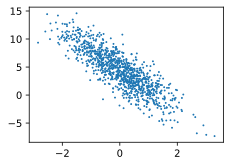

In [4]:
def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

# # 在../d2lzh_pytorch里面添加上面两个函数后就可以这样导入
# import sys
# sys.path.append("..")
# from d2lzh_pytorch import * 

set_figsize()
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1);

## 3.2.2 读取数据

In [5]:
# 本函数已保存在d2lzh包中方便以后使用
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)]) # 最后一次可能不足一个batch
        yield  features.index_select(0, j), labels.index_select(0, j)
        # NOTE: index_select(x, dim, index) 其中x是要索引的对象，dim=0表示按行索引，1表示按列索引，index是一个tensor，是indices


In [6]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 1.1888, -0.2832],
        [-1.0592,  1.5106],
        [-0.6916, -0.0648],
        [-1.5836,  0.9325],
        [ 1.6913,  1.1941],
        [-0.9228, -0.1668],
        [-0.7206, -0.8145],
        [ 0.1509,  0.8149],
        [ 0.5358,  0.4989],
        [ 1.2956,  0.3442]]) 
 tensor([ 7.5197, -3.0554,  3.0402, -2.1231,  3.5181,  2.9139,  5.5172,  1.7187,
         3.5636,  5.6299])


## 3.2.3 初始化模型参数

In [7]:
# 我们将权重初始化成均值为0、标准差为0.01的正态随机数，偏差则初始化成0。
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)

In [9]:
# 之后的模型训练中，需要对这些参数求梯度来迭代参数的值
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True) 

tensor([0.], requires_grad=True)

## 3.2.4 定义模型

In [10]:
# 下面是线性回归的矢量计算表达式的实现。我们使用mm函数做矩阵乘法。
def linreg(X, w, b):  # 本函数已保存在d2lzh包中方便以后使用
    return torch.mm(X, w) + b

## 3.2.5 定义损失函数

In [11]:
# 我们使用上一节描述的平方损失来定义线性回归的损失函数。
# 在实现中，我们需要把真实值y变形成预测值y_hat的形状。（为什么？）
# 以下函数返回的结果也将和y_hat的形状相同。
def squared_loss(y_hat, y):  # 本函数已保存在pytorch_d2lzh包中方便以后使用
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

## 3.2.6 定义优化算法

In [12]:
# 以下的sgd函数实现了上一节中介绍的小批量随机梯度下降算法。它通过不断迭代模型参数来优化损失函数。
# 这里自动求梯度模块计算得来的梯度是一个批量样本的梯度和。我们将它除以批量大小来得到平均值。
def sgd(params, lr, batch_size):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    for param in params:
        param.data -= lr * param.grad / batch_size # 注意这里更改param时用的param.data

## 3.2.7 训练模型

在训练中，我们将多次迭代模型参数。
在每次迭代中，我们根据当前读取的小批量数据样本（特征X和标签y），通过调用反向函数backward计算小批量随机梯度，并调用优化算法sgd迭代模型参数。
由于我们之前设批量大小batch_size为10，每个小批量的损失l的形状为(10, 1)。
回忆一下自动求梯度一节。由于变量l并不是一个标量，所以我们可以调用.sum()将其求和得到一个标量，再运行l.backward()得到该变量有关模型参数的梯度。
注意在每次更新完参数后不要忘了将参数的梯度清零。

在一个迭代周期（epoch）中，我们将完整遍历一遍data_iter函数，并对训练数据集中所有样本都使用一次（假设样本数能够被批量大小整除）。
这里的迭代周期个数num_epochs和学习率lr都是超参数，分别设3和0.03。在实践中，大多超参数都需要通过反复试错来不断调节。
虽然迭代周期数设得越大模型可能越有效，但是训练时间可能过长。而有关学习率对模型的影响，我们会在后面“优化算法”一章中详细介绍。

In [13]:
lr = 0.03   # learning rate
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):  # 训练模型一共需要num_epochs个迭代周期
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次（假设样本数能够被批量大小整除）。X
    # 和y分别是小批量样本的特征和标签
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y).sum()  # l是有关小批量X和y的损失
        l.backward()  # 小批量的损失对模型参数求梯度
        sgd([w, b], lr, batch_size)  # 使用小批量随机梯度下降迭代模型参数
        
        # 不要忘了梯度清零
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))

epoch 1, loss 0.043183
epoch 2, loss 0.000200
epoch 3, loss 0.000051


In [13]:
print(true_w, '\n', w)
print(true_b, '\n', b)

[2, -3.4] 
 tensor([[ 2.0000],
        [-3.3996]], requires_grad=True)
4.2 
 tensor([4.1990], requires_grad=True)
